# M3 – Week 2
### Bag of Visual Words for Image Classification

#### Team 6
- Alex Carrillo Alza
- Eduard Hogea
- Guillem Martinez Sanchez


### **Table of Contents**

*   [1. Dataset](#dataset)
*   [2. Dense SIFT](#dense-sift)
*   [Normalization](#normalization)
*   [Spatial Pyramids](#pyramids)
*   [3. SVM Classifier](#svm)

In [24]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm.notebook import tqdm
from typing import Tuple
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score
import optuna
import cv2
from typing import List, Tuple, Dict

In [15]:
def compute_visual_words(descriptors: np.ndarray, desc: str, codebook: MiniBatchKMeans, codebook_size: int = 128, verbose: bool = False) -> np.ndarray:
    """
    Computes the visual words of a set of descriptors given a codebook
    """
    visual_words = np.zeros((len(descriptors), codebook_size), dtype=np.float32)
    not_det = 0
    for i in tqdm(range(len(descriptors)), desc=desc, position=0, leave=verbose):
        if descriptors[i] is None:
            not_det += 1
            visual_words[i,:] = np.zeros(codebook_size, dtype=np.float32)
        else:
            words = codebook.predict(descriptors[i])
            visual_words[i,:] = np.bincount(words, minlength=codebook_size)
    if verbose:
        print(f"\nGenerated {visual_words.shape[0]} histograms with a k={visual_words.shape[1]} vocabulary.")
        print(f'\nNumber of images where keypoints were not detected: {not_det}')
    return visual_words

In [16]:
def dimensionality_reduction(X_train: np.ndarray, Y_train: np.ndarray, X_validate: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function applies dimensionality reduction to the training and validation data.

    Args:
        trial (int): The trial number
        X_train (np.ndarray): The training data
        Y_train (np.ndarray): The training labels, needed for supervised dimensionality reduction
        X_validate (np.ndarray): The validation data
    """
    lda = LinearDiscriminantAnalysis(n_components=7) # 7 is the best parameter from last week, no need to do hyperparam search
    X_train_DR = lda.fit_transform(X_train, Y_train)
    X_validate_DR = lda.transform(X_validate)

    return X_train_DR, X_validate_DR

In [17]:
def evaluate_vw_predictions(visual_words,test_labels, knn):
    """
    This function prints and returns the predictions' accuracy
    """
    score = knn.score(visual_words, test_labels)
    print(f'\nThe trained model generates results with {100*score} accuracy.')
    return score

## 1. Dataset <a id="dataset"></a>

In [18]:
train_images_filenames = pickle.load(open('../MIT_split/train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('../MIT_split/test_images_filenames.dat','rb'))
train_labels = pickle.load(open('../MIT_split/train_labels.dat','rb'))
test_labels = pickle.load(open('../MIT_split/test_labels.dat','rb'))

In [19]:
class Dataset():
    def __init__(self, images_filenames, labels):
        self.data = images_filenames
        self.labels = labels
    
    def visualize(self, samples_per_class=5):
        print(f'Total number of training samples: {len(self.data)}')
        # get unique classses
        classes = np.unique(np.array(self.labels))
        num_classes = len(classes)
        #set size for plot
        plt.figure(figsize=(15,8))

        for y, cls in enumerate(classes):
            _idxs = np.flatnonzero(np.array(self.labels) == cls)
            idxs = np.random.choice(_idxs, samples_per_class, replace=False)
            for i, idx in enumerate(idxs):
                plt_idx = i * num_classes + y + 1
                plt.subplot(samples_per_class, num_classes, plt_idx)
                plt.imshow(Image.open(self.data[idx]))
                plt.axis('off')
                if i == 0:
                    plt.title(f'{cls} ({len(_idxs)})')
        plt.show()
        
    def show_sample(self, indx):
        return Image.open(self.data[indx])


train = Dataset(train_images_filenames, train_labels)
test = Dataset(test_images_filenames, test_labels)

Total number of training samples: 1881


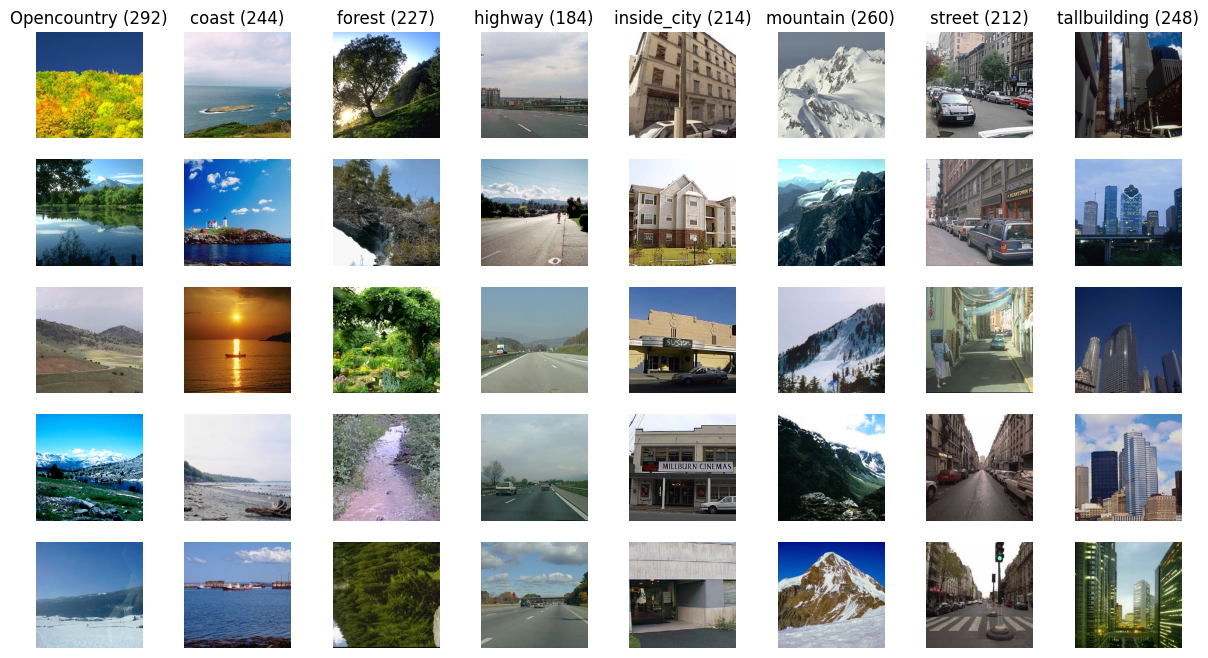

In [20]:
train.visualize()

## Dense SIFT <a id="dense-sift"></a>

In [34]:
# To create dense keypoints
def create_dense_kp(img_shape, step_div_size=50, num_sizes=1):
    keypoints = []
    init_step_size_x = max(img_shape[1] // step_div_size, 8)
    init_step_size_y = max(img_shape[0] // step_div_size, 8)
    for i in range(1, num_sizes+1):
        current_step_size_x = init_step_size_x * i
        current_step_size_y = init_step_size_y * i
        kp_size = (current_step_size_x + current_step_size_y) // 2
        keypoints += [cv2.KeyPoint(x, y, kp_size) for y in range(0, img_shape[0], current_step_size_y) 
                                                  for x in range(0, img_shape[1], current_step_size_x)]
    return keypoints

# let's sample an image
sample = train_images_filenames[100]
img=cv2.imread(sample)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# To compute dense SIFT
SIFTdetector = cv2.SIFT_create()
dense_kp = create_dense_kp(gray.shape, step_div_size=10, num_sizes=1)                              
_,dense_sift_des = SIFTdetector.compute(gray, dense_kp)

In [35]:
def show_keypoints(img_path, descriptor=None, kps=None):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if kps is None:
        kp = descriptor.detect(gray)
    else:
        kp = kps

    kp_img = cv2.drawKeypoints(img, kp, gray)
    fig,axes = plt.subplots(1,2, figsize=(8,4))
    titles = ['Original_image',f'Keypoints:{len(kp)}']
    images = [img, kp_img]
    for ax, image, title in zip(axes.flatten(), images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

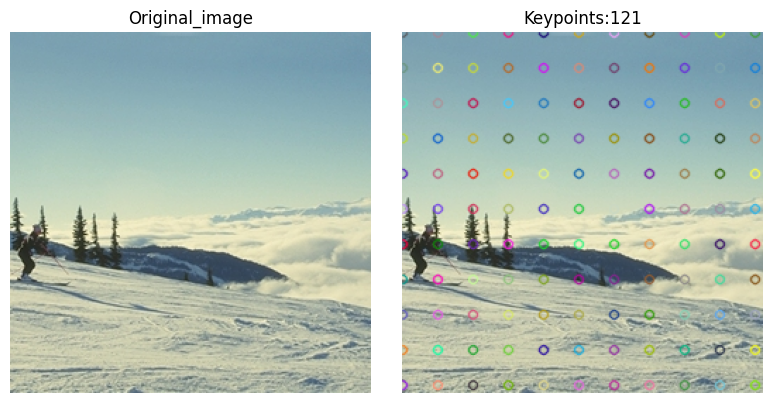

In [36]:
# Show dense keypoints
show_keypoints(sample, kps=dense_kp)

## Normalization <a id="normalization"></a>


Normalization is the process of scaling individual samples to have unit norm, to have features in the same scale and improve model performance. We use it to normalize the histograms of visual words.

The normalized feature vector is 
$$
x_{\text {norm }} = \frac{x}{N}
$$
with

- **L1 norm** $\to$ components of the feature vector sum 1
$$
N = \|x\|_{1} = \sum_{i}|x_{i}|
$$

- **L2 norm (euclidean)** $\to$ modulus of the feature vector is 1
$$
N = \|x\|_{2} = \sqrt{\sum_{i}x_i^2}
$$

- **Max norm**
$$
N = \|x\|_{\infty} = \max |x_{i}|
$$

- **Standar Scaler** $\to$ remove the mean and scale to unit variance
$$
x_{\text {norm }}=\frac{x-\mu}{\sigma} ; \quad \mu: \text{mean}, \ \sigma: \text{std}
$$

In [22]:
def normalization(X: np.ndarray, norm='scaler'):
    if norm == 'l1':
        return normalize(X, norm='l1')
    elif norm == 'l2':
        return normalize(X, norm='l2')
    elif norm == 'max':
        return normalize(X, norm='max')
    elif norm == 'scaler':
        return StandardScaler().fit_transform(X)

## Spatial Pyramids <a id="pyramids"></a>

In [39]:
def spatial_pyramid_square(img, descriptor, level=1, step_div_size=20, num_sizes=1, plot=False):

    # create dense keypoints and compute descriptors
    dense_kp = create_dense_kp(img.shape, step_div_size=step_div_size, num_sizes=num_sizes)
    _,des = descriptor.compute(img, dense_kp)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    # for visualization purposes
    if plot:
        fig = plt.figure(figsize=(15,5))
        gs = fig.add_gridspec(4*level, 4+4*level)
        ax = fig.add_subplot(gs[:, :4])
        ax.imshow(img)
        ax.axis('off')

    # list that contains the descriptors of img at different levels,
    # being pyramid_descriptors[0] the descriptors of the whole image
    pyramid_descriptors = [des]

    # pyramid_descriptors[1:4] -> descriptors of the four cells (of size 1/4 of the image size)
    # ...

    for l in range(1,level+1):
        level_factor = 2*l
        cell_h = int(gray.shape[0]/level_factor)
        cell_w = int(gray.shape[1]/level_factor)
        
        dense_kp_cell = create_dense_kp([cell_h,cell_w], step_div_size=step_div_size, num_sizes=num_sizes)
            
        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            for f_w in range(level_factor):
                shift_w = f_w*cell_w
                cell = img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w]
                _,des = descriptor.compute(cell, dense_kp_cell)
                pyramid_descriptors.append(des)

                # for visualization purposes
                if plot:
                    init_row = f_h*4//l
                    last_row = init_row + 4//l
                    init_col = f_w*4//(2*l) + 4*l
                    last_col = init_col + 4//(2*l)
                    ax = fig.add_subplot(gs[init_row:last_row, init_col:last_col])
                    ax.imshow(img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w])
                    ax.axis('off')


    return pyramid_descriptors

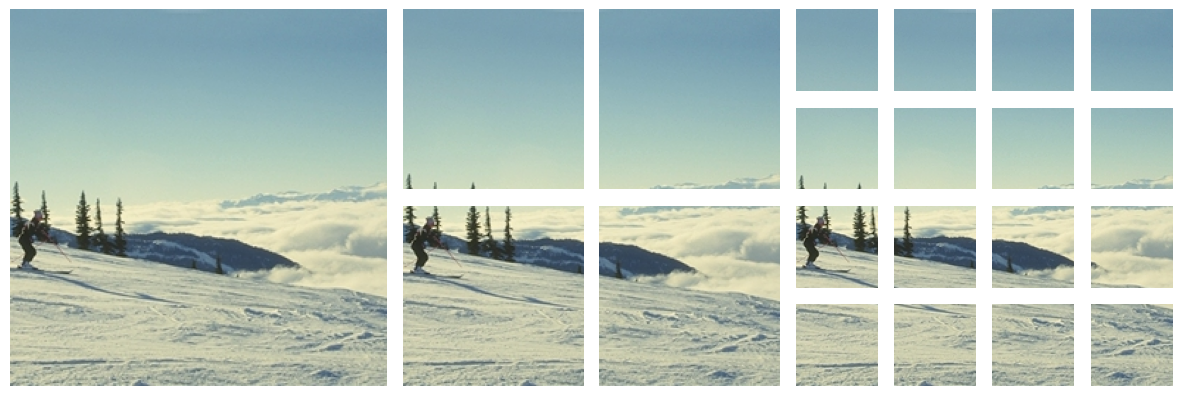

In [40]:
img_blocks = spatial_pyramid_square(img, SIFTdetector, level=2, plot=True)

## 3. SVM Classifier <a id="svm"></a>

In [ ]:
def histogram_intersection(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Function that implements a histogram intersection. This can be used as a Kernel for svm.SVC

    Args:
        X (np.ndarray): First histogram
        Y (np.ndarray): Second histogram
    """
    inter_kernel = np.zeros((X.shape[0], Y.shape[0]))
    for x_col, y_col in zip(X, Y):
        inter_kernel += np.minimum(x_col, y_col) 
    return inter_kernel

In [ ]:
def svm_classifier_fit(trial: int, X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray) -> np.ndarray:
        """
        Function that implements a SVM classifier. This function is used for hyperparameter optimization of parameters C and kernel.

        Args:
                trial (int): Trial number
                X_train (np.ndarray): Training data
                Y_train (np.ndarray): Training labels
                X_test (np.ndarray): Test data
        """
        c = trial.suggest_float("C", 1.0, 2.0)
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid", histogram_intersection])
        degree = 3
        coef0 = 0.0
        gamma = "scale"
        if kernel == "poly":
                degree = trial.suggest_categorical("poly_degree", [3, 4, 5])
        if kernel == "sigmoid" or kernel == "poly":
                coef0 = trial.suggest_float("coef0", 0.0, 1.0)
        if kernel == "rbf" or kernel == "sigmoid" or kernel == "poly":
                gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
        svc = SVC(C=c, kernel=kernel, degree=degree, coef0=coef0, gamma=gamma ,random_state=0)
        svc.fit(X_train, Y_train)
        Y_test = svc.predict(X_test)
        
        return Y_test

In [ ]:
def objective(trial, descriptors: np.ndarray, labels: np.ndarray, codebook: MiniBatchKMeans, codebook_size: int) -> float:
    """
    Function that implements the objective function for hyperparameter optimization. This function is used for hyperparameter optimization of parameters C and kernel.
    
    Args:
        descriptors (np.ndarray): precomputed descriptors
        labels (np.ndarray): Labels
        codebook (MiniBatchKMeans): Codebook
        codebook_size (int): Codebook size
    """
    n_splits = 5
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0).split(descriptors, labels)
    cumulative_accuracy = 0
    is_first_fold = True
    for train_index, test_index in tqdm(folds, "Fold", leave=False):
        X_train, Y_train = descriptors[train_index], train_labels[train_index]
        X_val, Y_val = descriptors[train_index], train_labels[train_index]
        
        vw_train, vw_val = compute_visual_words(X_train, X_val)
        X_train_DR, X_validate_DR = dimensionality_reduction(vw_train, Y_train, vw_val)
        predictions = svm_classifier_fit(trial, X_train_DR, Y_train, X_validate_DR)
        val_score = accuracy_score(y_true=Y_val, y_pred=predictions)
        cumulative_accuracy += val_score

        # fix trial for following folds. All params must be same accross folds
        if is_first_fold:
            is_first_fold = False
            trial = optuna.trial.FixedTrial(trial.params)

    accuracy = cumulative_accuracy / n_splits

    return accuracy

In [ ]:
# Wrap the objective inside a lambda and call objective inside it
func = lambda trial: objective(trial, descriptors=train_descriptors, labels=test_labels, codebook=codebook, codebook_size=codebook_size)

study = optuna.create_study(direction="maximize", study_name='svm-study', storage='sqlite:///final60.db', load_if_exists=True)
study.optimize(func, n_trials=50)